In [1]:
import numpy as np
import matplotlib.pyplot as plt
from common.layers import *

In [2]:
# コンテキストベクトルの擬似計算

T, H = 5, 4
hs = np.random.randn(T, H) # 各時系列の隠れベクトル
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02]) # 各単語の重み

# 重みのブロードキャスト
ar = a.reshape(5, 1).repeat(4, axis=1)
print(ar.shape)

# 積
t = hs *ar
print(t.shape)

# 和
c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [3]:
np.dot(a, hs) # バッチだとこの積は容易ではない。

array([-0.19513588, -0.17750218, -1.14963322, -0.65974764])

In [4]:
np.sum(ar * hs, axis=0)

array([-0.19513588, -0.17750218, -1.14963322, -0.65974764])

In [5]:
test = a.reshape(5, 1)
np.sum(test * hs,0)

array([-0.19513588, -0.17750218, -1.14963322, -0.65974764])

In [6]:
# バッチ処理の場合
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)

ar = a.reshape(N, T, 1).repeat(H, axis = 2)

t = hs * ar
print(t.shape)

c = np.sum(t, axis = 1)
print(c.shape)

(10, 5, 4)
(10, 4)


In [7]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None


    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis= 2)
        t = hs * ar
        c = np.sum(t, axis=1)
        self.cache = (hs, ar)
        return c


    def backward(self, dc): # dcのshape:(N, H)
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2) # daのshape:(N, T)
        return dhs, da

In [8]:
# 重みの計算
# バッチ処理の場合
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)

hr = h.reshape(N, 1, H).repeat(T, axis = 1)

# 内積で類似を算出
t = hs * hr
print(t.shape)

s = np.sum(t, axis = 2) # shape:(N, T)
print(s.shape)

# 確率へ
softmax = Softmax()
a = softmax.forward(s)
print(a.shape)



(10, 5, 4)
(10, 5)
(10, 5)


In [9]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

In [10]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


In [11]:
# atteintionのtime版
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

In [37]:
from common.time_layers import *
from common.base_model import *


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        enbed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, H*4) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, H*4) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(H*4).astype('f')

        self.embed = TimeEmbedding(enbed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False) # １ブロックでdecoderに渡すので保持する理由がない

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None


    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]


    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh # 最後の時系列以外は廃棄なので0のまま　-> 伝える勾配がない
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


In [38]:
# attention EncoderはEncoderのオーバーライド

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs

        return hs


    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [46]:
# attention DecoderのDecoder版

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

In [47]:
test = np.random.randn(2, 5, 3)

In [48]:
test

array([[[-0.38379501, -0.36437676,  0.16894265],
        [ 0.37076233, -0.81422866,  0.08485127],
        [ 1.36395924, -0.88351526, -1.68189959],
        [ 0.53943249,  0.80206472,  1.26049588],
        [ 0.38578445,  1.85341543, -0.54630614]],

       [[-1.85564922, -0.18356177, -0.47929522],
        [ 0.99216542,  0.38965594,  1.95460473],
        [ 0.68099375, -0.1497169 ,  0.07718722],
        [-0.50733876, -0.0965801 , -0.3374526 ],
        [ 0.51915228, -0.66268027, -0.00960841]]])

In [49]:
test[:, -1]

array([[ 0.38578445,  1.85341543, -0.54630614],
       [ 0.51915228, -0.66268027, -0.00960841]])

In [50]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [51]:

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [53]:
from hidden_others.dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# データ準備
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()
print("x_train shape:", x_train.shape)
print("t_train shape:", t_train.shape)
print("x_test shape:", x_test.shape)
print("t_test shape:", t_test.shape)


# 入力の反転
x_train, x_text = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vacab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size=vacab_size, wordvec_size=wordvec_size, hidden_size=hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)


acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    # epoch毎の評価
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]] # shapeを二次元にしたままにする
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse = True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print(f'val acc {acc * 100}')

x_shape: (45000, 29)
data_size 45000
| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 9[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 19[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 29[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 39[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 47[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 56[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 65[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 74[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 83[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 92[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 101[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 110[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 119[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 127[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 137[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 146[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 154[s] | loss 1.00
Q 10/15/94

In [54]:
model.save_params()

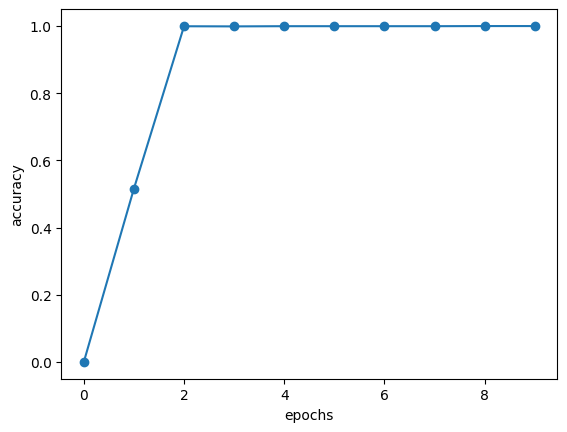

In [55]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

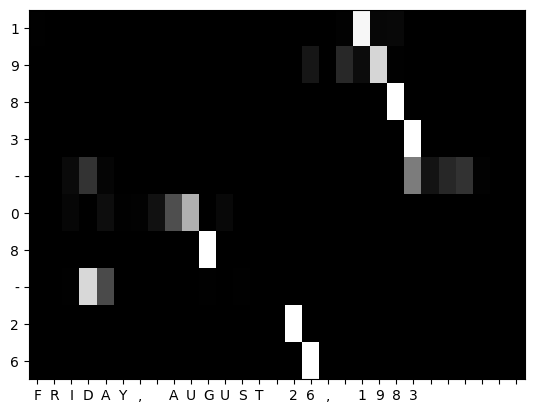

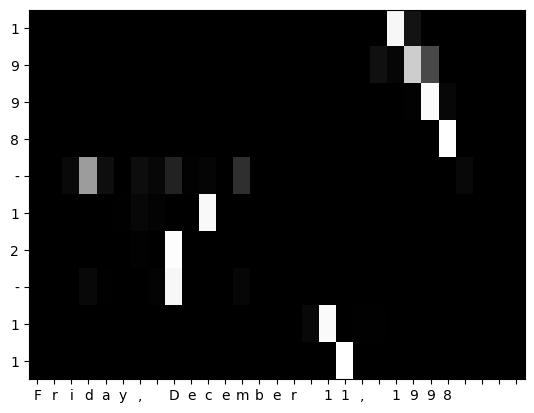

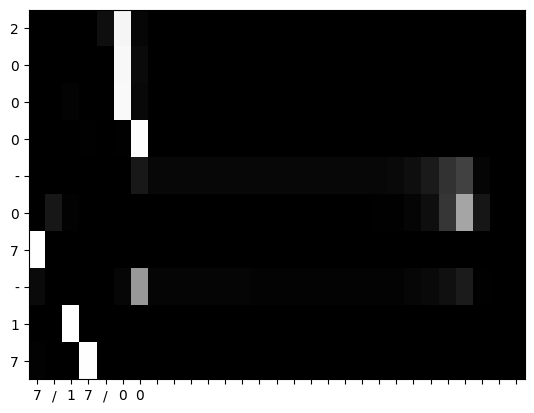

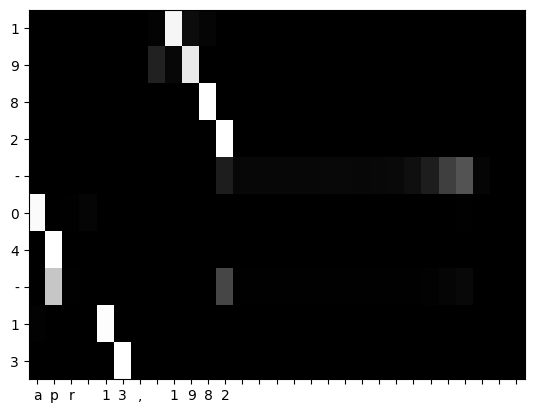

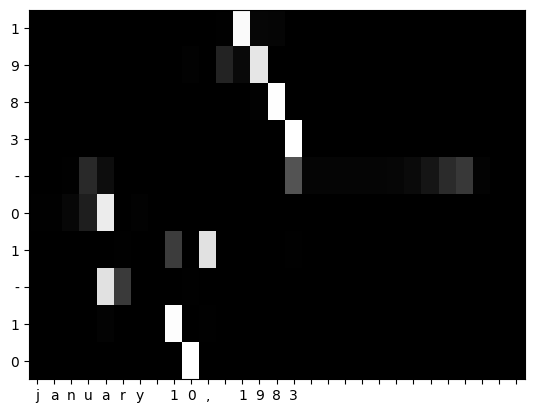

In [56]:
# 可視化

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0

def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)